In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
import warnings

from dtscalibration import read_silixa_files

from dtscalibration.datastore_utils import suggest_cable_shift_double_ended, shift_double_ended
import numpy as np
import scipy.stats as st 
from scipy import signal
import scipy
%matplotlib notebook


warnings.simplefilter("ignore")  # Hide warnings to avoid clutter in the notebook

In [3]:
### List of the file paths to process ###
filepaths = [
    'Antarctica_lastYear/',
    'Antarctica_5min/',
    'Antarctica_30min',
    'Antarctica_10sec'
]

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk


<IPython.core.display.Javascript object>


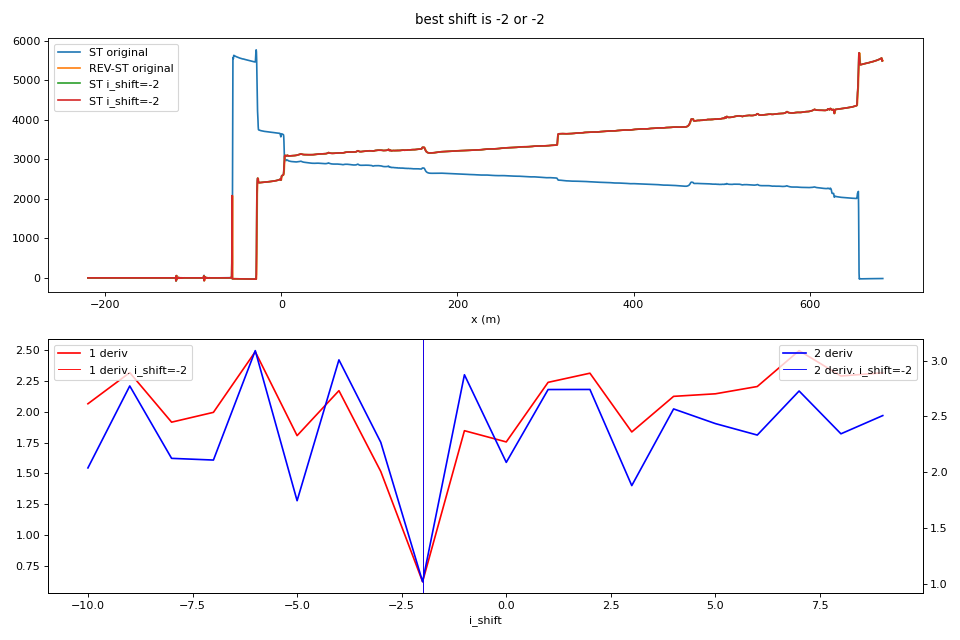

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
64 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk


<IPython.core.display.Javascript object>


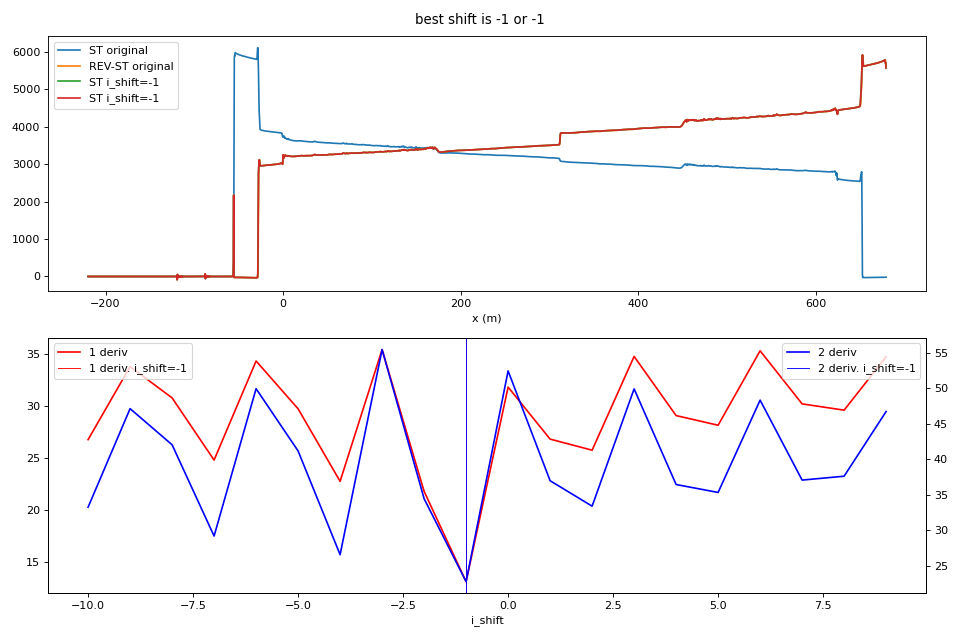

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
8 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk


<IPython.core.display.Javascript object>


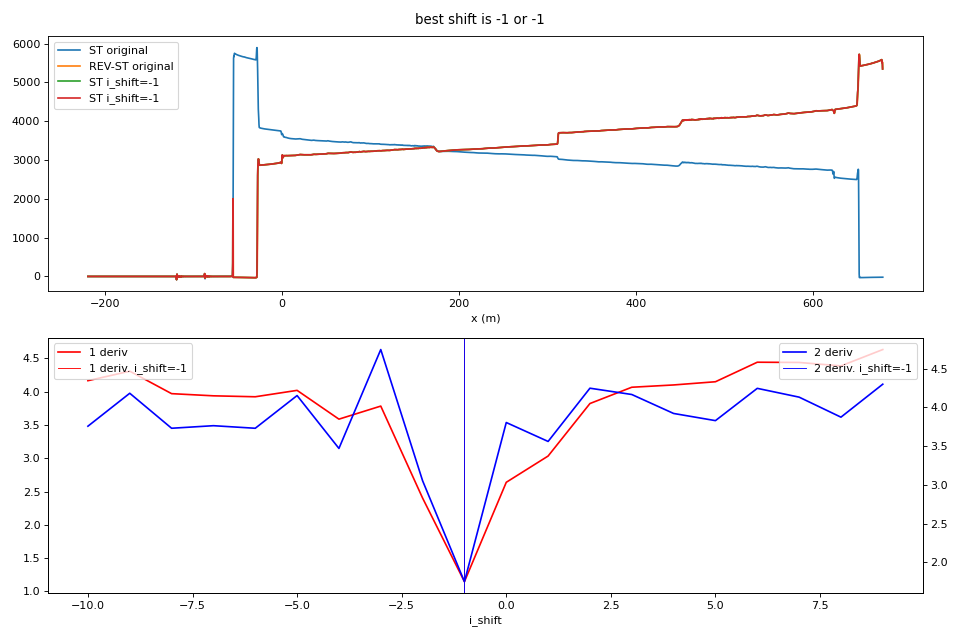

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
78 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk


<IPython.core.display.Javascript object>


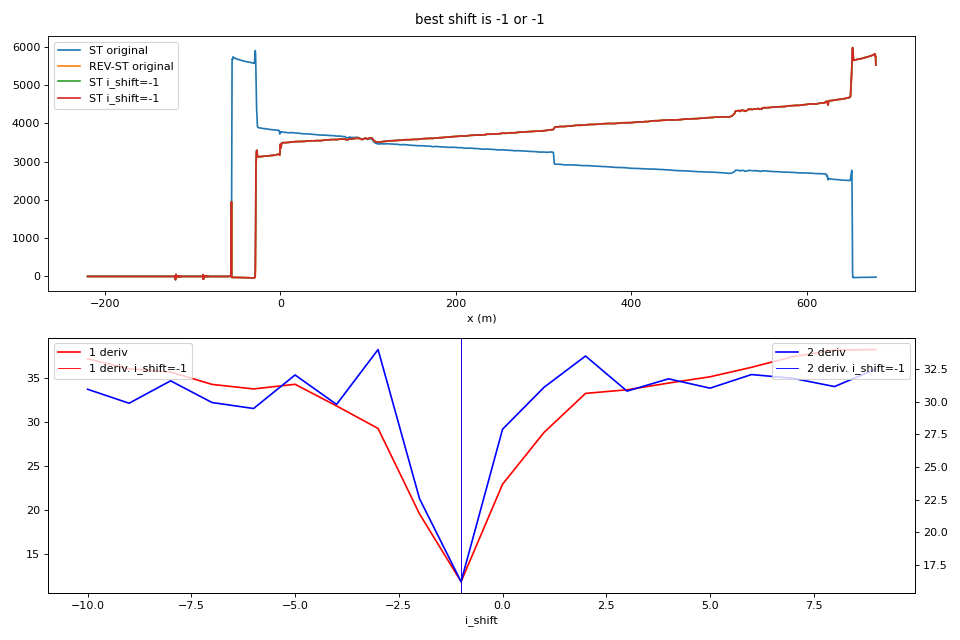

I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']


In [244]:
data = {}
for i in filepaths:

    ds = read_silixa_files(
        directory=i,
        timezone_netcdf='UTC',
        file_ext='*.xml')

    suggested_shift = suggest_cable_shift_double_ended(
        ds,
        np.arange(-10, 10),
        plot_result=True,
        figsize=(12,8))

    ds_restored = shift_double_ended(ds, suggested_shift[0])
    ds = ds_restored

    sections = {
    "referenceTemperature": [slice(-23, -3)], 
    }
    ds.sections = sections
    
#     matching_sections = [
#     (slice(74.8, 104.62), slice(518.95, 548.77), True)
#     ]
    
    st_var, resid = ds.variance_stokes(st_label='st')
    ast_var, _ = ds.variance_stokes(st_label='ast')
    rst_var, _ = ds.variance_stokes(st_label='rst')
    rast_var, _ = ds.variance_stokes(st_label='rast')

    ds.calibration_double_ended(
        st_var=st_var,
        ast_var=ast_var,
        rst_var=rst_var,
        rast_var=rast_var,
        #matching_sections=matching_sections,
        store_tmpw='tmpw',
        method='wls',
        solver='sparse')
    if i == 'Antarctica_lastYear/':
        
        data['ALHIC1901_22_30min'] = [ds]
        
    elif i == 'Antarctica_5min/':

        holder1 = []
        holder2 = []
        holder3 = []
        holder4 = []
        holder5 = []

        for j in range(len(ds.time)):
            if j < 11:
                holder1.append(ds.isel(time=j))
            if 11 <= j < 42:
                holder2.append(ds.isel(time=j))

            if 43 <= j < 49:
                holder3.append(ds.isel(time=j))

            if 49 <= j < 62:
                holder4.append(ds.isel(time=j))

            if j >= 62:
                holder5.append(ds.isel(time=j))
        data['ALHIC1901_23_5min'] = holder1
        data['ALHIC1903_23_5min'] = holder2
        data['ALHIC1902_23_5min'] = holder3
        data['Eclipse_23_5min'] = holder4
        data['ALHIC2201_23_5min'] = holder5
    elif i == 'Antarctica_30min':
        holder1 = []
        holder2 = []
        for j in range(len(ds.time)):
            if j == 0:
                holder1.append(ds.isel(time=j))
            if j > 0:
                holder2.append(ds.isel(time=j))
        data['ALHIC1901_23_30min'] = holder1
        data['ALHIC1902_23_30min'] = holder2
    elif i == 'Antarctica_10sec':
        data['ALHIC1902_23_10sec'] = [ds]



<IPython.core.display.Javascript object>


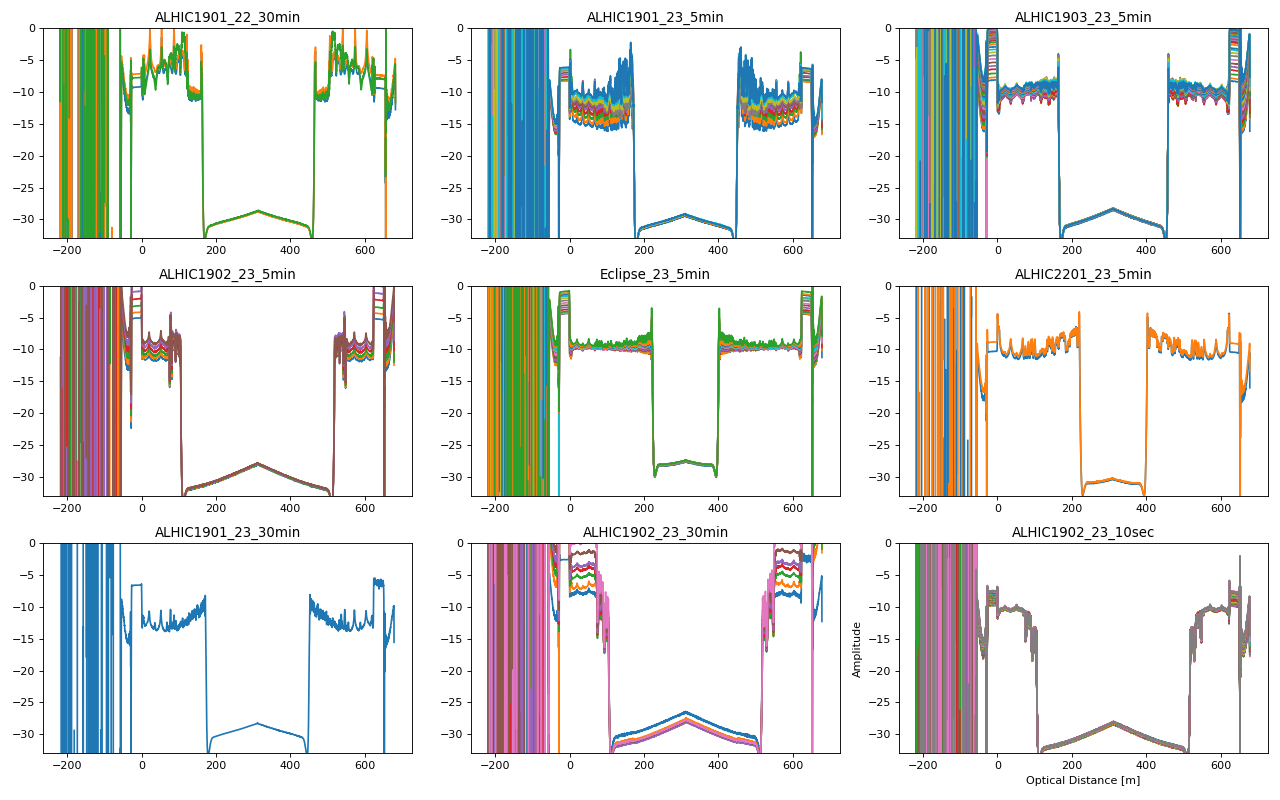

In [245]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=[16,10])
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
for i,ax in zip(data,ax_list):
    for j in data[i]:
        ax.plot(j.x, j.tmpw)
    ax.set_ylim([-33,0])
    ax.set_title(i)
plt.xlabel('Optical Distance [m]')
plt.ylabel('Amplitude')

ax1.get_shared_x_axes().join(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)
plt.tight_layout()

In [36]:
borehole_geometries = {

    'ALHIC1901_22_30min': [162.05, 313.05],
    'ALHIC1901_23_5min': [170.43, 311.04],
    'ALHIC1903_23_5min': [163.82, 311.04],
    'ALHIC1902_23_5min': [104.07, 311.04],
    'Eclipse_23_5min': [220.75, 311.04],
    'ALHIC2201_23_5min': [220.0, 311.04],
    'ALHIC1901_23_30min': [170.93, 311.04], 
    'ALHIC1902_23_30min': [104.30, 311.04], 
    'ALHIC1902_23_10sec': [104.30, 311.04]
}


<IPython.core.display.Javascript object>


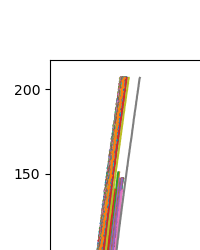

In [46]:
fig, ax = plt.subplots(figsize=[4,5])

for off,(i,k) in enumerate(zip(data, borehole_geometries)):
    for j in data[i]:
        x = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x
        y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
        ax.plot(y, x - borehole_geometries[k][0])

<IPython.core.display.Javascript object>


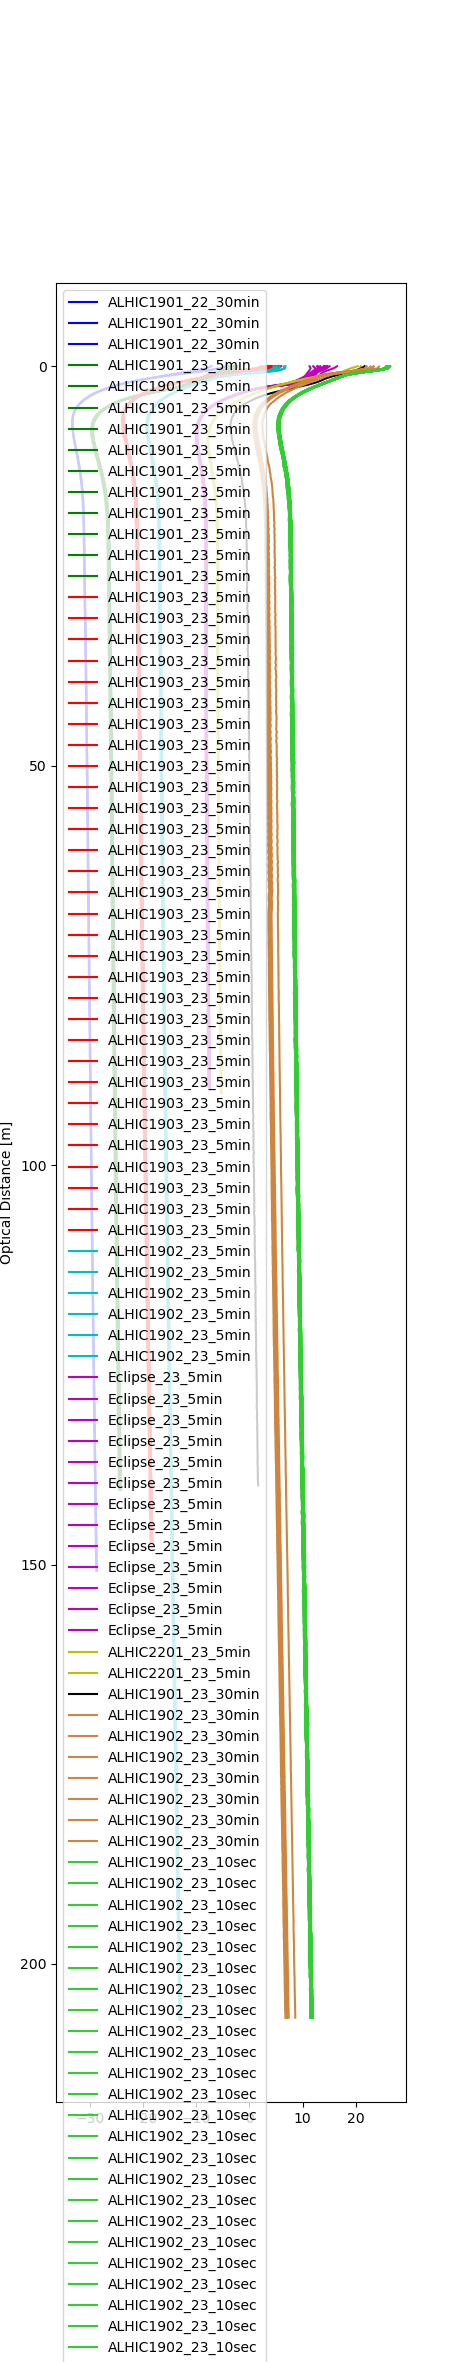

In [53]:
# fig, ax = plt.subplots(figsize=[4,5])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'peru', 'limegreen']
all_data_dict = {}
for off,(i,k,c) in enumerate(zip(data, borehole_geometries, colors)):

    
    for j in data[i]:
        x = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x
        y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
        ax.plot(y+(off*5), x - borehole_geometries[k][0], label=i, color=c)
    #ax.set_ylim([-33,0])
    
# plt.ylabel('Optical Distance [m]')
# plt.legend()
# plt.gca().invert_yaxis()
# plt.tight_layout()

In [177]:
allData_dict = {}

for i,k in zip(data, borehole_geometries):
    print(i)

    if i == 'ALHIC1901_22_30min':
        for j in data[i]:
            x = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr = np.asarray(y)
            allData_dict[i] = x, arr
    elif i == 'ALHIC1901_23_5min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'ALHIC1903_23_5min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'ALHIC1902_23_5min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'Eclipse_23_5min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'ALHIC2201_23_5min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'ALHIC1901_23_30min':
        for j in data[i]:
            x = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr = np.asarray(y)
            allData_dict[i] = x, arr
    elif i == 'ALHIC1902_23_30min':
        x = data[i][0].sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
        arr = np.zeros((len(data[i]), len(x)))
        for num,j in enumerate(data[i]):
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr[num,:] = np.asarray(y)
        allData_dict[i] = x, arr.T
    elif i == 'ALHIC1902_23_10sec':
        for j in data[i]:
            x = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).x.values
            y = j.sel(x=slice(borehole_geometries[k][0],borehole_geometries[k][1])).tmpw
            arr = np.asarray(y)
            allData_dict[i] = x, arr

ALHIC1901_22_30min
ALHIC1901_23_5min
ALHIC1903_23_5min
ALHIC1902_23_5min
Eclipse_23_5min
ALHIC2201_23_5min
ALHIC1901_23_30min
ALHIC1902_23_30min
ALHIC1902_23_10sec


<IPython.core.display.Javascript object>


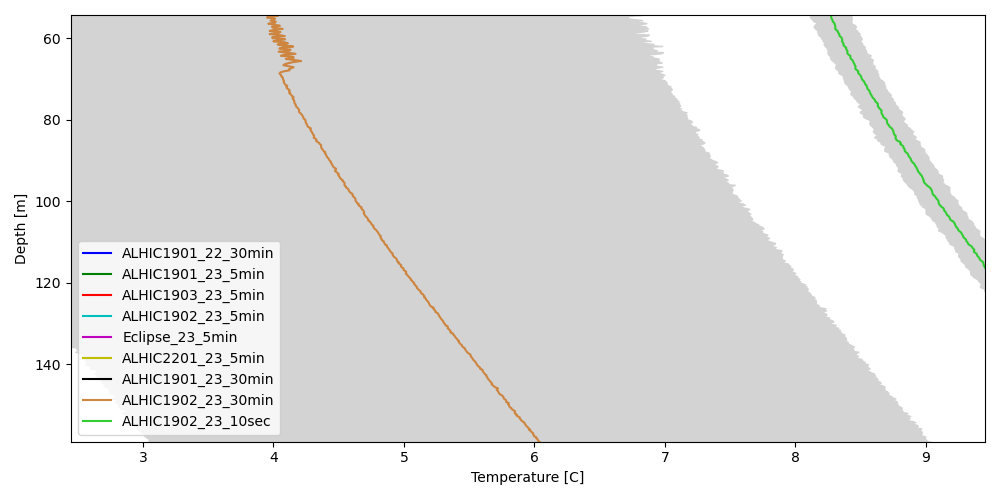

In [207]:
# fig, ax = plt.subplots(figsize=[4,5])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'peru', 'limegreen']
fig, ax = plt.subplots(figsize=(10,5))
for off, (i, c) in enumerate(zip(allData_dict, colors)):

    x = allData_dict[i][0] - borehole_geometries[i][0]
    y = allData_dict[i][1]
    if i == 'ALHIC1901_23_30min':
        mean = y

        ax.plot(mean + (off *5),x, label=i, color=c)

    else:
        mean = np.mean(y, axis=1)
        ci95, ci05 = st.t.interval(alpha=0.95, df=len(allData_dict[i])-1, 
              loc=mean, 
              scale=st.sem(y, axis=1)) 


        ax.plot(mean + (off *5),x, label=i, color=c)
        ax.fill_betweenx(x,ci05+ (off *5), ci95+ (off *5), color='lightgrey')

plt.ylim([-10,210])
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Temperature [C]')
plt.tight_layout()

<IPython.core.display.Javascript object>


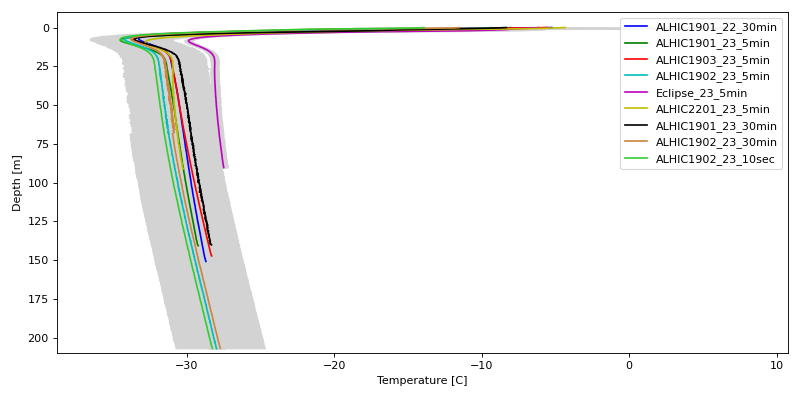

In [242]:
# fig, ax = plt.subplots(figsize=[4,5])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'peru', 'limegreen']
fig, ax = plt.subplots(figsize=(10,5))
for off, (i, c) in enumerate(zip(allData_dict, colors)):

    x = allData_dict[i][0] - borehole_geometries[i][0]
    y = allData_dict[i][1]
    if i == 'ALHIC1901_23_30min':
        mean = y

        ax.plot(mean + (off *0),x, label=i, color=c)

    else:
        mean = np.mean(y, axis=1)
        ci95, ci05 = st.t.interval(alpha=0.95, df=len(allData_dict[i])-1, 
              loc=mean, 
              scale=st.sem(y, axis=1)) 


        ax.plot(mean + (off *0),x, label=i, color=c)
        ax.fill_betweenx(x,ci05+ (off *0), ci95+ (off *0), color='lightgrey')

plt.ylim([-10,210])
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Temperature [C]')
plt.tight_layout()

<IPython.core.display.Javascript object>


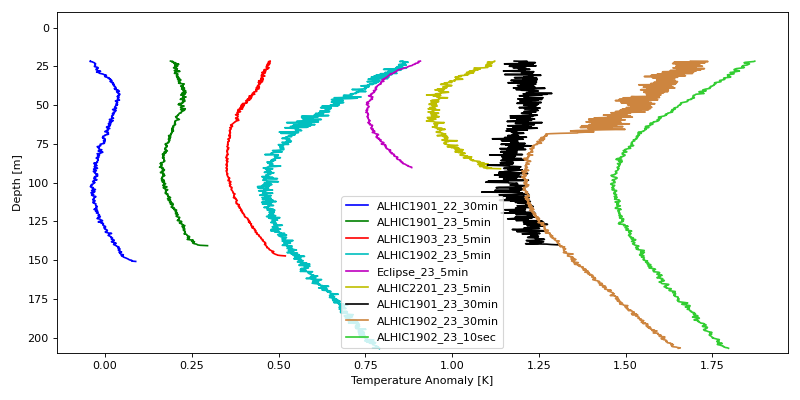

In [220]:
# fig, ax = plt.subplots(figsize=[4,5])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'peru', 'limegreen']
fig, ax = plt.subplots(figsize=(10,5))

bp=85
    
for off, (i, c) in enumerate(zip(allData_dict, colors)):

    x = allData_dict[i][0] - borehole_geometries[i][0]
    y = allData_dict[i][1]
    if i == 'ALHIC1901_23_30min':
        mean = y
        detrend = scipy.signal.detrend(mean, type='linear', bp=bp, overwrite_data=False)
        ax.plot(detrend[bp:] + (off *.2),x[bp:], label=i, color=c)

    else:
        mean = np.mean(y, axis=1)

        detrend = scipy.signal.detrend(mean, type='linear', bp=bp, overwrite_data=False)
        ax.plot(detrend[bp:] + (off *.2),x[bp:], label=i, color=c)
        #ax.fill_betweenx(x,ci05+ (off *5), ci95+ (off *5), color='lightgrey')

plt.ylim([-10,210])
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Temperature Anomaly [K]')
plt.tight_layout()

<IPython.core.display.Javascript object>


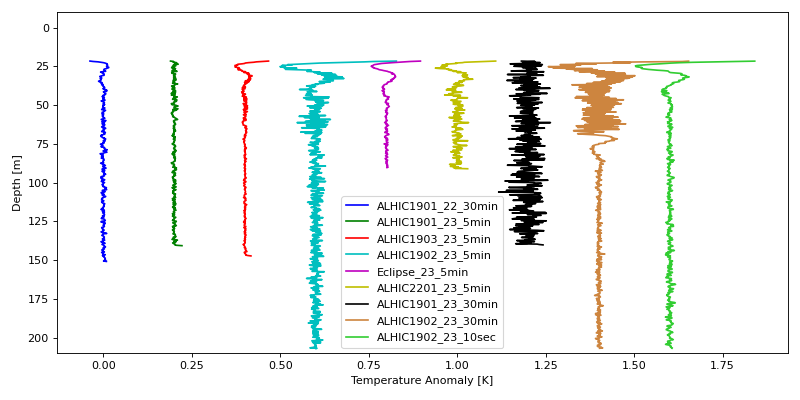

In [241]:
sos = signal.butter(4, .06, 'hp', fs=4, output='sos')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'peru', 'limegreen']
fig, ax = plt.subplots(figsize=(10,5))
for off, (i, c) in enumerate(zip(allData_dict, colors)):

    x = allData_dict[i][0] - borehole_geometries[i][0]
    y = allData_dict[i][1]
    if i == 'ALHIC1901_23_30min':
        mean = y
        detrend = scipy.signal.detrend(mean, type='linear', bp=bp, overwrite_data=False)
        filtered= signal.sosfilt(sos, detrend[bp:])
        ax.plot(filtered + (off *.2),x[bp:], label=i, color=c)

    else:
        mean = np.mean(y, axis=1)


        detrend_mean = scipy.signal.detrend(mean, type='linear', bp=bp, overwrite_data=False)
        filtered_mean = signal.sosfilt(sos, detrend_mean[bp:])
        ax.plot(filtered_mean + (off *.2),x[bp:], label=i, color=c)


plt.ylim([-10,210])
plt.legend()
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Temperature Anomaly [K]')
plt.tight_layout()

array([-14.20455577, -14.54557687, -16.4530132 , -19.46172538,
       -21.71627327, -22.88912621, -23.83086136, -24.84316581,
       -25.86628933, -26.8663269 , -27.8208578 , -28.71778705,
       -29.53410903, -30.2700596 , -30.92303563, -31.51898019,
       -32.05092952, -32.5262236 , -32.93538922, -33.28343165,
       -33.57030653, -33.81989161, -34.03149256, -34.20132455,
       -34.35270299, -34.4669873 , -34.53768754, -34.59155228,
       -34.6301032 , -34.64515191, -34.63729136, -34.61801305,
       -34.58634321, -34.54088601, -34.49248528, -34.44131054,
       -34.37494547, -34.30924498, -34.24917208, -34.16577575,
       -34.08930752, -34.01441713, -33.92969941, -33.83793763,
       -33.77041301, -33.70197055, -33.61846673, -33.5563125 ,
       -33.49023218, -33.43399003, -33.3590881 , -33.28822874,
       -33.22057074, -33.16291594, -33.11989732, -33.06315913,
       -32.99584549, -32.94269335, -32.90922878, -32.86866319,
       -32.8335298 , -32.79852124, -32.75101712, -32.71

array([-13.61131759, -14.03529403, -16.04413986, -19.14271008,
       -21.43950252, -22.63463527, -23.58694462, -24.58209324,
       -25.60502445, -26.60478491, -27.55021658, -28.43312126,
       -29.24696359, -29.98332554, -30.65217152, -31.23931406,
       -31.77056793, -32.22875905, -32.62046395, -32.96185998,
       -33.26765872, -33.52400808, -33.73367162, -33.91565398,
       -34.04564077, -34.15713977, -34.2391876 , -34.29284914,
       -34.32168533, -34.34219039, -34.35112084, -34.33025335,
       -34.29846392, -34.24737202, -34.18839533, -34.12466108,
       -34.06449084, -33.99147243, -33.91553632, -33.85867119,
       -33.78584033, -33.70191469, -33.6246097 , -33.55041314,
       -33.47716402, -33.40167704, -33.3250922 , -33.24253471,
       -33.17751039, -33.10073777, -33.02725132, -32.96694936,
       -32.9072616 , -32.84850979, -32.78911715, -32.73092608,
       -32.68845698, -32.65578973, -32.59766308, -32.5462327 ,
       -32.49873114, -32.46849896, -32.4390394 , -32.41